In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import sys
sys.path.append('../')
import os

In [18]:
output_folder=r"C:\Users\E284652\Documents\repos\pypvcircuit_output"

In [19]:
import unittest
from pypvcell.solarcell import SQCell, MJCell

from pypvcircuit.spice_module_solver import SingleModuleStringSolver, MultiStringModuleSolver
from pypvcell.illumination import load_astm
import pypvcell.fom as fom

import matplotlib.pyplot as plt
import numpy as np

from pypvcircuit.parse_spice_input import NodeReducer

In [20]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

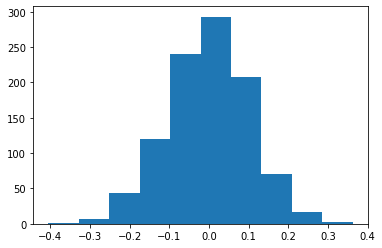

In [21]:
plt.hist(s)
plt.show()

In [22]:
gaas_1j = SQCell(1.42, 300, 1)
ingap_1j = SQCell(1.87, 300, 1)
ge_1j = SQCell(0.7, 300, 1)

mj_cell = MJCell([ingap_1j, gaas_1j, ge_1j])

nd = NodeReducer()

stdev = 0.02

cell_num_array = np.arange(1,15,1)
trial = 300
pm_store = np.empty((cell_num_array.shape[0], trial))
isc_store = np.empty((cell_num_array.shape[0], trial))
voc_store = np.empty((cell_num_array.shape[0], trial))
ff_store = np.empty((cell_num_array.shape[0], trial))

for std_index, cell_num in enumerate(cell_num_array):

    for tt in range(trial):
        test_string_num=5
        
        sm = MultiStringModuleSolver(solarcell=mj_cell, illumination=500,
                                     v_start=0, v_end=3.5 * cell_num, v_steps=0.05, l_r=1e-3, l_c=1e-3,
                                     cell_number=cell_num, string_number=test_string_num, isc_stdev=stdev,
                                     spice_preprocessor=None)

        # print(sm._generate_network())

        sm._solve_circuit()
        calc_isc=fom.isc(sm.V, sm.I)/test_string_num
        max_p = fom.max_power(sm.V, sm.I) / (cell_num * test_string_num)
        voc_p=fom.voc(sm.V,sm.I)/cell_num
        ff_p=fom.ff(sm.V,sm.I)
        plt.plot(sm.V,sm.I)
        plt.ylim(top=0)
        
        fname="{}_{}.png".format(std_index,tt)
        
        plt.savefig(os.path.join(output_folder,fname))
        plt.close()
        
        
        pm_store[std_index, tt] = max_p
        isc_store[std_index,tt] = calc_isc
        voc_store[std_index,tt]=voc_p
        ff_store[std_index,tt]=ff_p

In [23]:
from pypvcell.illumination import load_astm
mj_cell.set_input_spectrum(load_astm("AM1.5g")*500)

In [24]:
normal_p=mj_cell.get_eta()*1e-6*500*1000
normal_p

0.23228764743850291

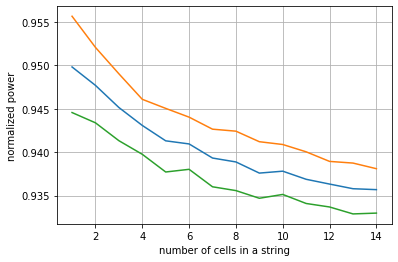

In [25]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(cell_num_array, pm_store.mean(axis=1)/normal_p)
#plt.plot(cell_num_array, pm_store.max(axis=1)/normal_p)
ax.plot(cell_num_array, np.percentile(pm_store/normal_p,75,axis=1))
ax.plot(cell_num_array, np.percentile(pm_store/normal_p,25,axis=1))

#plt.axhline(1.0)
ax.set_xlabel("number of cells in a string")
ax.set_ylabel("normalized power")
plt.grid()
plt.show()

In [26]:
cell_num_array.dtype

dtype('int32')

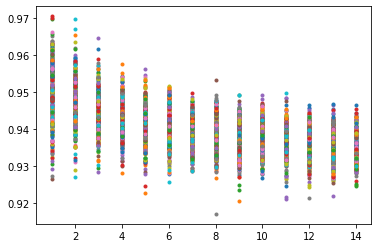

In [27]:
plt.plot(cell_num_array, pm_store/normal_p,'.')
plt.show()

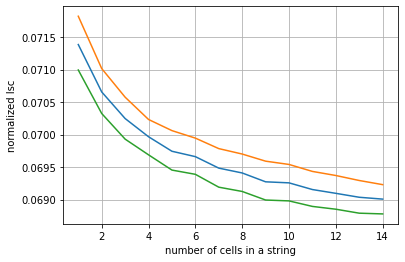

In [34]:
plt.plot(cell_num_array, -isc_store.mean(axis=1))
plt.plot(cell_num_array, np.percentile(-isc_store,75,axis=1))
plt.plot(cell_num_array, np.percentile(-isc_store,25,axis=1))

#plt.axhline(1.0)
plt.xlabel("number of cells in a string")
plt.ylabel("normalized Isc")
plt.grid()
plt.show()

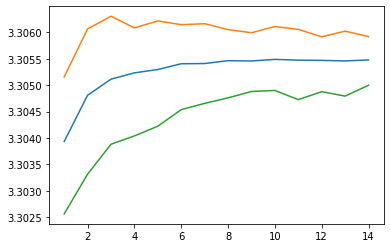

In [29]:
plt.plot(cell_num_array, voc_store.mean(axis=1))
plt.plot(cell_num_array, voc_store.max(axis=1))
plt.plot(cell_num_array, voc_store.min(axis=1))
plt.show()

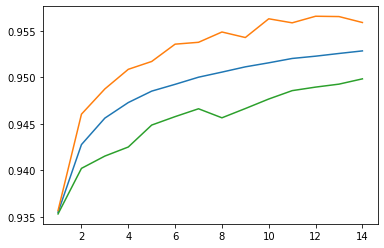

In [30]:
plt.plot(cell_num_array, ff_store.mean(axis=1))
plt.plot(cell_num_array, ff_store.max(axis=1))
plt.plot(cell_num_array, ff_store.min(axis=1))
plt.show()